# Step 7: Model Optimization

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import joblib
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.ensemble import VotingClassifier, StackingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder, StandardScaler
import warnings
warnings.filterwarnings('ignore')

BASE_PATH = Path('/home/alvaro-ibarra/smartwatch-stress-detection')
COMBINED_PATH = BASE_PATH / 'data' / 'processed' / 'combined'
MODELS_PATH = BASE_PATH / 'outputs' / 'models'
OUTPUT_PATH = BASE_PATH / 'outputs' / 'tables'
FIGURES_PATH = BASE_PATH / 'outputs' / 'figures'

print("Libraries loaded")

Libraries loaded


In [2]:
# Load combined dataset
df = pd.read_csv(COMBINED_PATH / 'combined_dataset_filled.csv')
print(f"Dataset: {df.shape[0]} windows, {df.shape[1]} columns")

# Separate features and labels
metadata_cols = ['subject_id', 'dataset', 'window_id', 'timestamp_start', 'timestamp_end', 'label']
feature_cols = [c for c in df.columns if c not in metadata_cols]
print(f"Features: {len(feature_cols)}")

X = df[feature_cols].values
y = df['label'].values

# Encode labels
le = joblib.load(MODELS_PATH / 'label_encoder.pkl')
y_encoded = le.transform(y)

# Scale features
scaler = joblib.load(MODELS_PATH / 'feature_scaler.pkl')
X_scaled = scaler.transform(X)

print(f"Classes: {le.classes_}")

Dataset: 10511 windows, 45 columns
Features: 39
Classes: ['Aerobic' 'Amusement' 'Anaerobic' 'Baseline' 'Emotion' 'Stress']


In [3]:
# Load pre-trained models
xgb_model = joblib.load(MODELS_PATH / 'xgboost.pkl')
rf_model = joblib.load(MODELS_PATH / 'random_forest.pkl')
mlp_model = joblib.load(MODELS_PATH / 'mlp.pkl')
gb_model = joblib.load(MODELS_PATH / 'gradient_boosting.pkl')
knn_model = joblib.load(MODELS_PATH / 'knn.pkl')

print("Models loaded:")
print("  - XGBoost")
print("  - Random Forest")
print("  - MLP")
print("  - Gradient Boosting")
print("  - KNN")

Models loaded:
  - XGBoost
  - Random Forest
  - MLP
  - Gradient Boosting
  - KNN


In [4]:
# 7.1 Ensemble Methods - Voting Classifier
print("="*60)
print("7.1 ENSEMBLE METHODS")
print("="*60)

# Hard Voting (majority vote)
voting_hard = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('mlp', mlp_model)
    ],
    voting='hard'
)

# Soft Voting (average probabilities)
voting_soft = VotingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('mlp', mlp_model)
    ],
    voting='soft'
)

print("Voting classifiers created (XGBoost + RF + MLP)")

7.1 ENSEMBLE METHODS
Voting classifiers created (XGBoost + RF + MLP)


In [5]:
# Cross-validation for voting classifiers
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

print("\nHard Voting CV...")
scores_hard = cross_val_score(voting_hard, X_scaled, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Hard Voting CV Accuracy: {scores_hard.mean():.4f} (+/- {scores_hard.std():.4f})")

print("\nSoft Voting CV...")
scores_soft = cross_val_score(voting_soft, X_scaled, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Soft Voting CV Accuracy: {scores_soft.mean():.4f} (+/- {scores_soft.std():.4f})")


Hard Voting CV...


/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have insta

Hard Voting CV Accuracy: 0.9525 (+/- 0.0027)

Soft Voting CV...


/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have insta

Soft Voting CV Accuracy: 0.9463 (+/- 0.0035)


In [6]:
# Stacking Classifier
print("\nStacking Classifier CV...")

stacking = StackingClassifier(
    estimators=[
        ('xgb', xgb_model),
        ('rf', rf_model),
        ('mlp', mlp_model)
    ],
    final_estimator=LogisticRegression(max_iter=1000, random_state=42),
    cv=5,
    n_jobs=-1
)

scores_stack = cross_val_score(stacking, X_scaled, y_encoded, cv=cv, scoring='accuracy', n_jobs=-1)
print(f"Stacking CV Accuracy: {scores_stack.mean():.4f} (+/- {scores_stack.std():.4f})")


Stacking Classifier CV...


/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have insta

Stacking CV Accuracy: 0.9278 (+/- 0.0046)


In [7]:
# Train best ensemble on full data
print("\nTraining Soft Voting on full data...")
voting_soft.fit(X_scaled, y_encoded)
joblib.dump(voting_soft, MODELS_PATH / 'voting_soft.pkl')

print("Training Stacking on full data...")
stacking.fit(X_scaled, y_encoded)
joblib.dump(stacking, MODELS_PATH / 'stacking.pkl')

print("Ensemble models saved")


Training Soft Voting on full data...
Training Stacking on full data...


/home/alvaro-ibarra/miniconda/envs/jupyter-env/lib/python3.10/site-packages/xgboost/core.py:377: FutureWarning: Your system has an old version of glibc (< 2.28). We will stop supporting Linux distros with glibc older than 2.28 after **May 31, 2025**. Please upgrade to a recent Linux distro (with glibc >= 2.28) to use future versions of XGBoost.
Note: You have installed the 'manylinux2014' variant of XGBoost. Certain features such as GPU algorithms or federated learning are not available. To use these features, please upgrade to a recent Linux distro with glibc 2.28+, and install the 'manylinux_2_28' variant.
  warnings.warn(
[15:32:46] WARNING: /croot/xgboost-split_1749630910898/work/src/context.cc:203: XGBoost is not compiled with CUDA support.
[15:32:46] WARNING: /croot/xgboost-split_1749630910898/work/src/context.cc:203: XGBoost is not compiled with CUDA support.
[15:32:46] WARNING: /croot/xgboost-split_1749630910898/work/src/context.cc:203: XGBoost is not compiled with CUDA support

Ensemble models saved


In [8]:
# 7.2 Deep Learning - 1D CNN
print("\n" + "="*60)
print("7.2 DEEP LEARNING APPROACHES")
print("="*60)

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv1D, MaxPooling1D, Flatten, Dropout, LSTM, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.model_selection import train_test_split

# Check GPU
print(f"TensorFlow version: {tf.__version__}")
print(f"GPU available: {len(tf.config.list_physical_devices('GPU')) > 0}")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print(f"GPU: {tf.config.list_physical_devices('GPU')}")


7.2 DEEP LEARNING APPROACHES


2026-02-07 15:34:39.402389: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-07 15:34:39.679420: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI AVX512_BF16 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-07 15:34:41.061273: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


TensorFlow version: 2.20.0
GPU available: True
GPU: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [9]:
# Prepare data for CNN (reshape to 3D: samples, features, channels)
X_train, X_test, y_train, y_test = train_test_split(
    X_scaled, y_encoded, test_size=0.2, stratify=y_encoded, random_state=42
)

# Reshape for CNN: (samples, timesteps, features)
X_train_cnn = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_test_cnn = X_test.reshape(X_test.shape[0], X_test.shape[1], 1)

# One-hot encode labels
n_classes = len(le.classes_)
y_train_cat = to_categorical(y_train, n_classes)
y_test_cat = to_categorical(y_test, n_classes)

print(f"Train shape: {X_train_cnn.shape}")
print(f"Test shape: {X_test_cnn.shape}")
print(f"Classes: {n_classes}")

Train shape: (8408, 39, 1)
Test shape: (2103, 39, 1)
Classes: 6


In [10]:
# 1D CNN Model
def build_cnn(input_shape, n_classes):
    model = Sequential([
        Conv1D(64, 3, activation='relu', input_shape=input_shape, padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),
        
        Conv1D(128, 3, activation='relu', padding='same'),
        BatchNormalization(),
        MaxPooling1D(2),
        Dropout(0.3),
        
        Conv1D(256, 3, activation='relu', padding='same'),
        BatchNormalization(),
        Dropout(0.3),
        
        Flatten(),
        Dense(128, activation='relu'),
        Dropout(0.5),
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

cnn_model = build_cnn((X_train_cnn.shape[1], 1), n_classes)
cnn_model.summary()

I0000 00:00:1770500097.052476  120505 gpu_device.cc:2020] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 6153 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Laptop GPU, pci bus id: 0000:01:00.0, compute capability: 8.9


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 39, 64)         │           256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 39, 64)         │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 19, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 19, 128)        │        24,704 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 19, 128)        │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 9, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 9, 256)         │        98,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 9, 256)         │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 9, 256)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 2304)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       295,040 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 6)              │           774 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 421,126 (1.61 MB)

 Trainable params: 420,230 (1.60 MB)

 Non-trainable params: 896 (3.50 KB)

In [11]:
# Train CNN
callbacks = [
    EarlyStopping(patience=10, restore_best_weights=True, monitor='val_loss'),
    ReduceLROnPlateau(factor=0.5, patience=5, min_lr=1e-6)
]

print("Training 1D CNN...")
history_cnn = cnn_model.fit(
    X_train_cnn, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)

Training 1D CNN...
Epoch 1/100


2026-02-07 15:35:05.370756: I external/local_xla/xla/service/service.cc:163] XLA service 0x7ca9840079d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2026-02-07 15:35:05.370772: I external/local_xla/xla/service/service.cc:171]   StreamExecutor device (0): NVIDIA GeForce RTX 4060 Laptop GPU, Compute Capability 8.9
2026-02-07 15:35:05.403454: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2026-02-07 15:35:05.619935: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:473] Loaded cuDNN version 91500


 73/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.4022 - loss: 1.9495

I0000 00:00:1770500108.955889  123597 device_compiler.h:196] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


106/106 ━━━━━━━━━━━━━━━━━━━━ 8s 37ms/step - accuracy: 0.4886 - loss: 1.5072 - val_accuracy: 0.3823 - val_loss: 1.6869 - learning_rate: 0.0010
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.5784 - loss: 1.0860 - val_accuracy: 0.4209 - val_loss: 1.7193 - learning_rate: 0.0010
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6112 - loss: 0.9951 - val_accuracy: 0.5529 - val_loss: 1.1509 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6490 - loss: 0.8786 - val_accuracy: 0.6629 - val_loss: 0.8892 - learning_rate: 0.0010
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6600 - loss: 0.8546 - val_accuracy: 0.7277 - val_loss: 0.7127 - learning_rate: 0.0010
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6711 - loss: 0.8189 - val_accuracy: 0.7444 - val_loss: 0.6675 - learning_rate: 0.0010
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6980 - loss: 0.7627 - val_

In [12]:
# Evaluate CNN
cnn_loss, cnn_acc = cnn_model.evaluate(X_test_cnn, y_test_cat, verbose=0)
y_pred_cnn = np.argmax(cnn_model.predict(X_test_cnn, verbose=0), axis=1)
cnn_f1 = f1_score(y_test, y_pred_cnn, average='weighted')

print(f"\n1D CNN Test Accuracy: {cnn_acc:.4f}")
print(f"1D CNN Test F1: {cnn_f1:.4f}")

# Save CNN model
cnn_model.save(MODELS_PATH / 'cnn_1d.keras')
print("CNN model saved")

2026-02-07 15:35:33.922746: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_196', 20 bytes spill stores, 20 bytes spill loads




1D CNN Test Accuracy: 0.8845
1D CNN Test F1: 0.8840
CNN model saved


In [13]:
# Dense Neural Network (DNN) for comparison
def build_dnn(input_dim, n_classes):
    model = Sequential([
        Dense(256, activation='relu', input_shape=(input_dim,)),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(128, activation='relu'),
        BatchNormalization(),
        Dropout(0.4),
        
        Dense(64, activation='relu'),
        BatchNormalization(),
        Dropout(0.3),
        
        Dense(n_classes, activation='softmax')
    ])
    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
    return model

dnn_model = build_dnn(X_train.shape[1], n_classes)
dnn_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense_2 (Dense)                 │ (None, 256)            │        10,240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 256)            │         1,024 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 6)              │           390 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 53,574 (209.27 KB)

 Trainable params: 52,678 (205.77 KB)

 Non-trainable params: 896 (3.50 KB)

In [14]:
# Train DNN
print("\nTraining DNN...")
history_dnn = dnn_model.fit(
    X_train, y_train_cat,
    validation_split=0.2,
    epochs=100,
    batch_size=64,
    callbacks=callbacks,
    verbose=1
)


Training DNN...
Epoch 1/100


2026-02-07 15:35:48.068856: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:35:48.068887: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:35:48.068899: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:35:48.068907: I external/l

106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 20ms/step - accuracy: 0.3503 - loss: 1.8695 

2026-02-07 15:35:54.643132: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:35:54.643152: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:35:55.327206: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112', 16 bytes spill stores, 16 bytes spill loads

2026-02-07 15:35:55.398846: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 

106/106 ━━━━━━━━━━━━━━━━━━━━ 9s 38ms/step - accuracy: 0.4395 - loss: 1.5867 - val_accuracy: 0.5517 - val_loss: 1.1822 - learning_rate: 0.0010
Epoch 2/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5586 - loss: 1.1647 - val_accuracy: 0.5844 - val_loss: 0.9898 - learning_rate: 0.0010
Epoch 3/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.5950 - loss: 1.0510 - val_accuracy: 0.6397 - val_loss: 0.8930 - learning_rate: 0.0010
Epoch 4/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step - accuracy: 0.6188 - loss: 0.9597 - val_accuracy: 0.6772 - val_loss: 0.8246 - learning_rate: 0.0010
Epoch 5/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6386 - loss: 0.9162 - val_accuracy: 0.6908 - val_loss: 0.7919 - learning_rate: 0.0010
Epoch 6/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6512 - loss: 0.8850 - val_accuracy: 0.6992 - val_loss: 0.7708 - learning_rate: 5.0000e-04
Epoch 7/100
106/106 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.6522 - loss: 0.8775 - 

In [15]:
# Evaluate DNN
dnn_loss, dnn_acc = dnn_model.evaluate(X_test, y_test_cat, verbose=0)
y_pred_dnn = np.argmax(dnn_model.predict(X_test, verbose=0), axis=1)
dnn_f1 = f1_score(y_test, y_pred_dnn, average='weighted')

print(f"\nDNN Test Accuracy: {dnn_acc:.4f}")
print(f"DNN Test F1: {dnn_f1:.4f}")

# Save DNN model
dnn_model.save(MODELS_PATH / 'dnn.keras')
print("DNN model saved")

2026-02-07 15:36:38.740087: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:36:38.740105: I external/local_xla/xla/service/gpu/autotuning/dot_search_space.cc:208] All configs were filtered out because none of them sufficiently match the hints. Maybe the hints set does not contain a good representative set of valid configs? Working around this by using the full hints set instead.
2026-02-07 15:36:39.309960: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : Registers are spilled to local memory in function 'gemm_fusion_dot_112', 16 bytes spill stores, 16 bytes spill loads

2026-02-07 15:36:39.650629: I external/local_xla/xla/stream_executor/cuda/subprocess_compilation.cc:346] ptxas warning : 


DNN Test Accuracy: 0.5445
DNN Test F1: 0.4907
DNN model saved


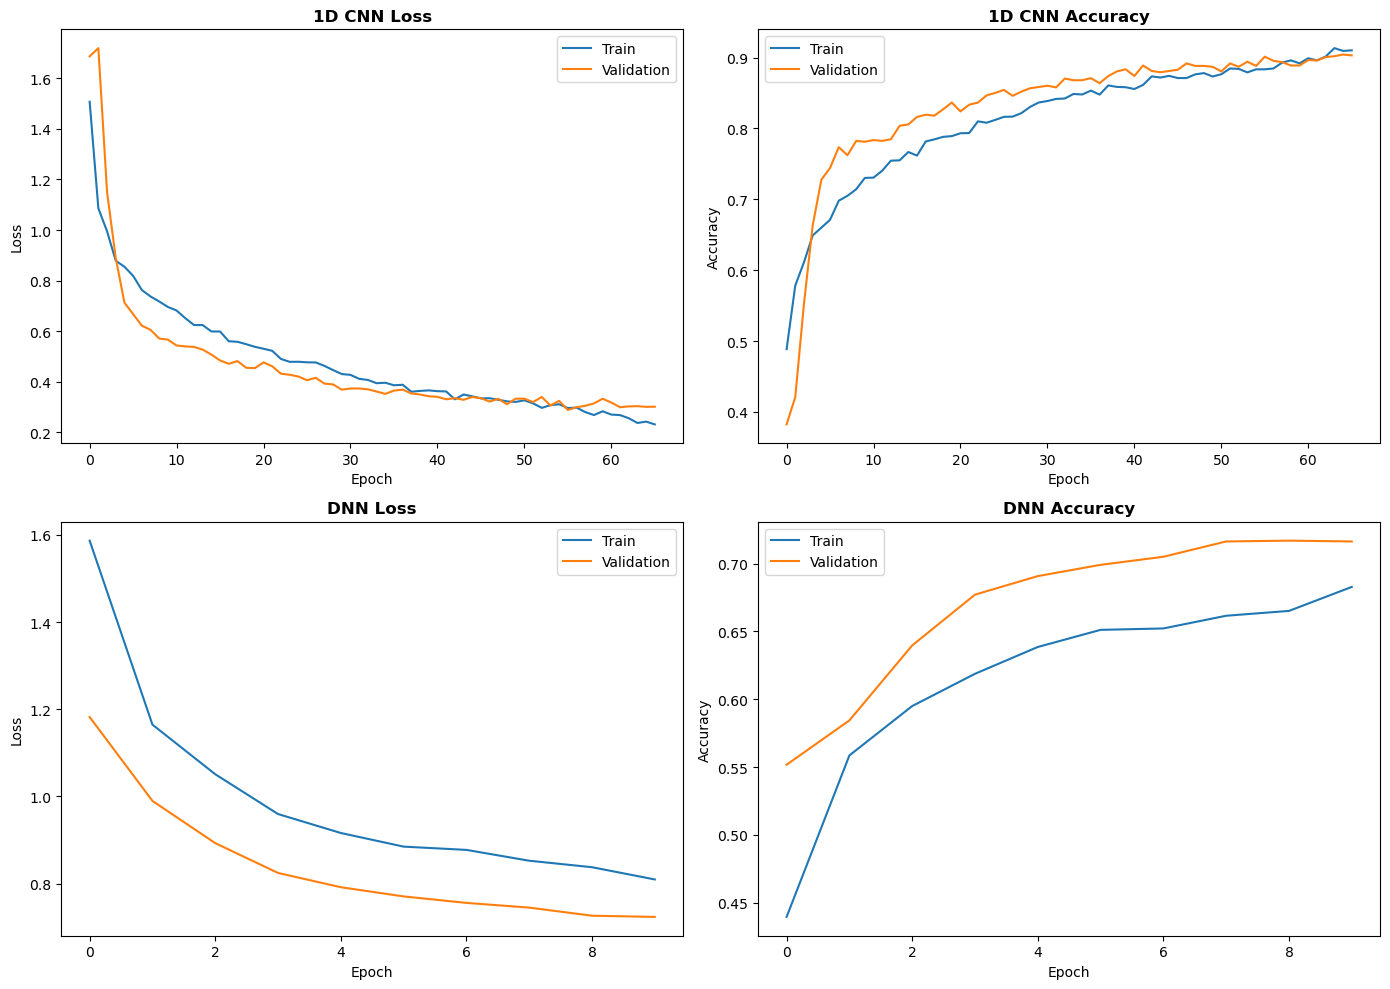

In [16]:
# Plot training history
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# CNN Loss
axes[0, 0].plot(history_cnn.history['loss'], label='Train')
axes[0, 0].plot(history_cnn.history['val_loss'], label='Validation')
axes[0, 0].set_title('1D CNN Loss', fontweight='bold')
axes[0, 0].set_xlabel('Epoch')
axes[0, 0].set_ylabel('Loss')
axes[0, 0].legend()

# CNN Accuracy
axes[0, 1].plot(history_cnn.history['accuracy'], label='Train')
axes[0, 1].plot(history_cnn.history['val_accuracy'], label='Validation')
axes[0, 1].set_title('1D CNN Accuracy', fontweight='bold')
axes[0, 1].set_xlabel('Epoch')
axes[0, 1].set_ylabel('Accuracy')
axes[0, 1].legend()

# DNN Loss
axes[1, 0].plot(history_dnn.history['loss'], label='Train')
axes[1, 0].plot(history_dnn.history['val_loss'], label='Validation')
axes[1, 0].set_title('DNN Loss', fontweight='bold')
axes[1, 0].set_xlabel('Epoch')
axes[1, 0].set_ylabel('Loss')
axes[1, 0].legend()

# DNN Accuracy
axes[1, 1].plot(history_dnn.history['accuracy'], label='Train')
axes[1, 1].plot(history_dnn.history['val_accuracy'], label='Validation')
axes[1, 1].set_title('DNN Accuracy', fontweight='bold')
axes[1, 1].set_xlabel('Epoch')
axes[1, 1].set_ylabel('Accuracy')
axes[1, 1].legend()

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'deep_learning_training.png', dpi=300, bbox_inches='tight')
plt.show()

In [17]:
# 7.3 Model Comparison Summary
print("\n" + "="*60)
print("7.3 MODEL COMPARISON SUMMARY")
print("="*60)

# Load previous results
prev_results = pd.read_csv(OUTPUT_PATH / 'model_comparison_results.csv')

# Evaluate individual models on test set for fair comparison
y_pred_xgb = xgb_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)
y_pred_mlp = mlp_model.predict(X_test)
y_pred_soft = voting_soft.predict(X_test)
y_pred_stack = stacking.predict(X_test)

comparison_results = {
    'Model': ['XGBoost', 'Random Forest', 'MLP', 'Soft Voting', 'Stacking', '1D CNN', 'DNN'],
    'Test Accuracy': [
        accuracy_score(y_test, y_pred_xgb),
        accuracy_score(y_test, y_pred_rf),
        accuracy_score(y_test, y_pred_mlp),
        accuracy_score(y_test, y_pred_soft),
        accuracy_score(y_test, y_pred_stack),
        cnn_acc,
        dnn_acc
    ],
    'Test F1': [
        f1_score(y_test, y_pred_xgb, average='weighted'),
        f1_score(y_test, y_pred_rf, average='weighted'),
        f1_score(y_test, y_pred_mlp, average='weighted'),
        f1_score(y_test, y_pred_soft, average='weighted'),
        f1_score(y_test, y_pred_stack, average='weighted'),
        cnn_f1,
        dnn_f1
    ],
    'CV Accuracy': [
        prev_results[prev_results['model'] == 'XGBoost']['cv_accuracy_mean'].values[0],
        prev_results[prev_results['model'] == 'Random Forest']['cv_accuracy_mean'].values[0],
        prev_results[prev_results['model'] == 'MLP']['cv_accuracy_mean'].values[0],
        scores_soft.mean(),
        scores_stack.mean(),
        np.nan,
        np.nan
    ]
}

comparison_df = pd.DataFrame(comparison_results)
comparison_df = comparison_df.sort_values('Test Accuracy', ascending=False)
comparison_df.to_csv(OUTPUT_PATH / 'optimization_comparison.csv', index=False)

print("\nModel Comparison (sorted by Test Accuracy):")
print(comparison_df.to_string(index=False))


7.3 MODEL COMPARISON SUMMARY

Model Comparison (sorted by Test Accuracy):
        Model  Test Accuracy  Test F1  CV Accuracy
      XGBoost       1.000000 1.000000     0.951289
Random Forest       1.000000 1.000000     0.931310
          MLP       1.000000 1.000000     0.890211
  Soft Voting       1.000000 1.000000     0.946342
     Stacking       1.000000 1.000000     0.927790
       1D CNN       0.884451 0.883994          NaN
          DNN       0.544460 0.490707          NaN


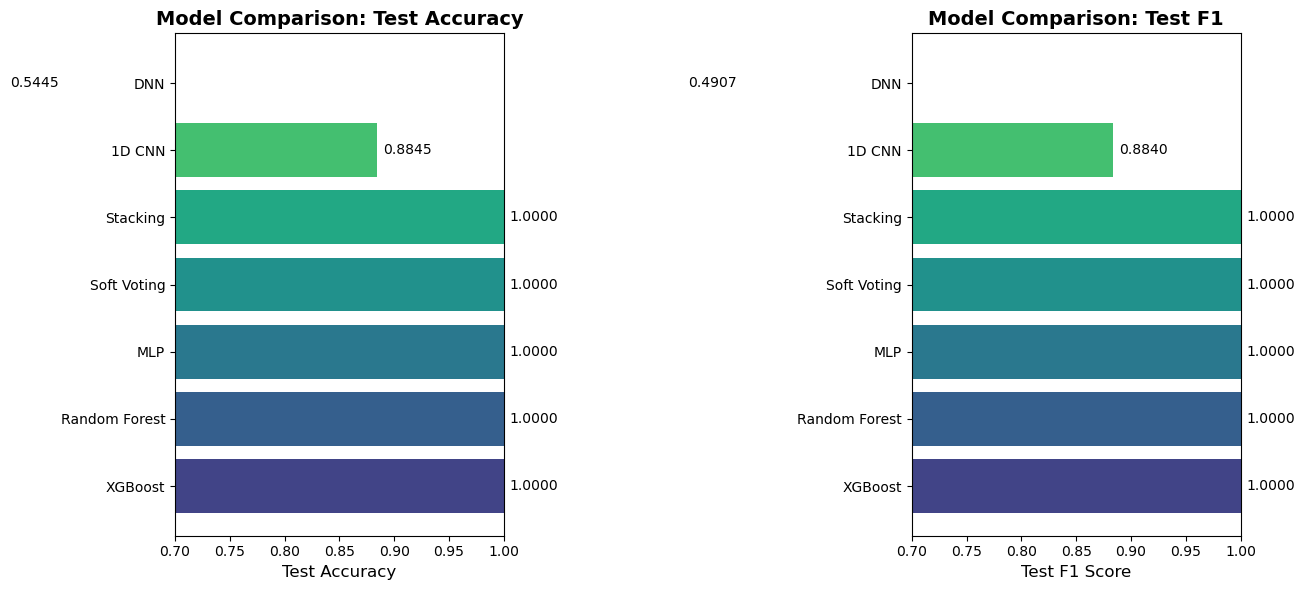

In [18]:
# Visualization
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# Test Accuracy comparison
colors = plt.cm.viridis(np.linspace(0.2, 0.8, len(comparison_df)))
axes[0].barh(comparison_df['Model'], comparison_df['Test Accuracy'], color=colors)
axes[0].set_xlabel('Test Accuracy', fontsize=12)
axes[0].set_title('Model Comparison: Test Accuracy', fontsize=14, fontweight='bold')
axes[0].set_xlim(0.7, 1.0)
for i, v in enumerate(comparison_df['Test Accuracy']):
    axes[0].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

# F1 comparison
axes[1].barh(comparison_df['Model'], comparison_df['Test F1'], color=colors)
axes[1].set_xlabel('Test F1 Score', fontsize=12)
axes[1].set_title('Model Comparison: Test F1', fontsize=14, fontweight='bold')
axes[1].set_xlim(0.7, 1.0)
for i, v in enumerate(comparison_df['Test F1']):
    axes[1].text(v + 0.005, i, f'{v:.4f}', va='center', fontsize=10)

plt.tight_layout()
plt.savefig(FIGURES_PATH / 'optimization_comparison.png', dpi=300, bbox_inches='tight')
plt.show()


Best Model: XGBoost


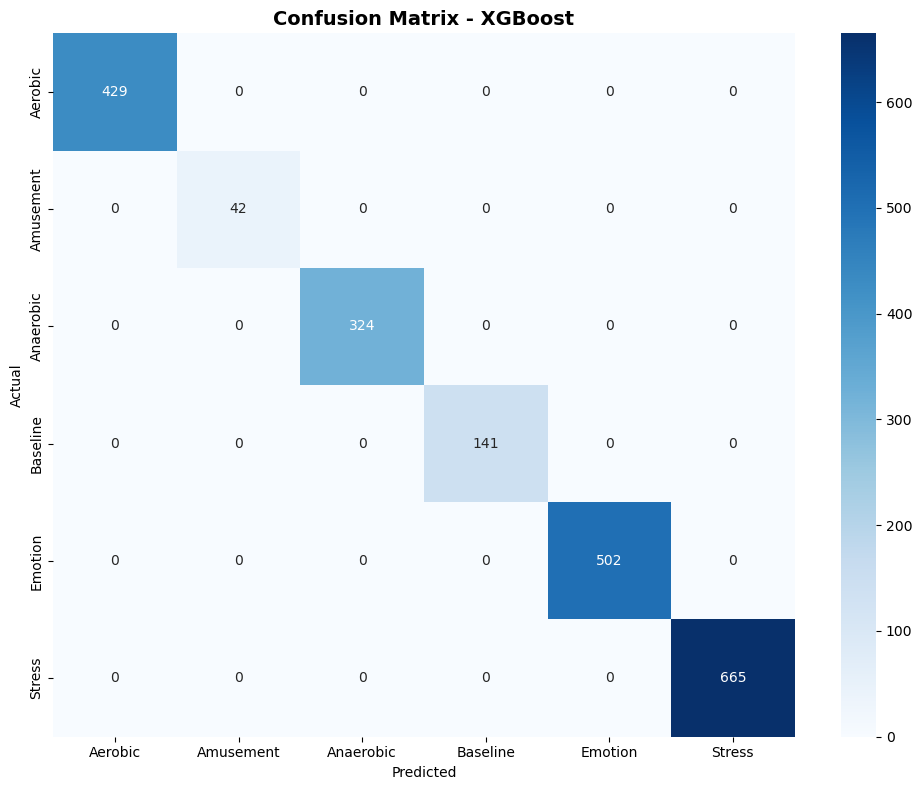


Classification Report - XGBoost:
              precision    recall  f1-score   support

     Aerobic       1.00      1.00      1.00       429
   Amusement       1.00      1.00      1.00        42
   Anaerobic       1.00      1.00      1.00       324
    Baseline       1.00      1.00      1.00       141
     Emotion       1.00      1.00      1.00       502
      Stress       1.00      1.00      1.00       665

    accuracy                           1.00      2103
   macro avg       1.00      1.00      1.00      2103
weighted avg       1.00      1.00      1.00      2103



In [19]:
# Best model confusion matrix
best_model_name = comparison_df.iloc[0]['Model']
print(f"\nBest Model: {best_model_name}")

# Get predictions for best model
if best_model_name == 'Soft Voting':
    y_pred_best = y_pred_soft
elif best_model_name == 'Stacking':
    y_pred_best = y_pred_stack
elif best_model_name == 'XGBoost':
    y_pred_best = y_pred_xgb
elif best_model_name == '1D CNN':
    y_pred_best = y_pred_cnn
elif best_model_name == 'DNN':
    y_pred_best = y_pred_dnn
else:
    y_pred_best = y_pred_rf

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_best)
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f'Confusion Matrix - {best_model_name}', fontsize=14, fontweight='bold')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig(FIGURES_PATH / 'best_model_confusion.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\nClassification Report - {best_model_name}:")
print(classification_report(y_test, y_pred_best, target_names=le.classes_))

In [20]:
# Summary
print("\n" + "="*60)
print("STEP 7 COMPLETE: Model Optimization")
print("="*60)

print("\nEnsemble Models:")
print(f"  - Soft Voting CV: {scores_soft.mean():.4f}")
print(f"  - Stacking CV: {scores_stack.mean():.4f}")

print("\nDeep Learning Models:")
print(f"  - 1D CNN Test: {cnn_acc:.4f}")
print(f"  - DNN Test: {dnn_acc:.4f}")

print(f"\nBest Overall Model: {best_model_name}")
print(f"  - Test Accuracy: {comparison_df.iloc[0]['Test Accuracy']:.4f}")
print(f"  - Test F1: {comparison_df.iloc[0]['Test F1']:.4f}")

print("\nModels Saved:")
print("  - voting_soft.pkl")
print("  - stacking.pkl")
print("  - cnn_1d.keras")
print("  - dnn.keras")

print("\nFigures:")
print("  - deep_learning_training.png")
print("  - optimization_comparison.png")
print("  - best_model_confusion.png")

print("="*60)


STEP 7 COMPLETE: Model Optimization

Ensemble Models:
  - Soft Voting CV: 0.9463
  - Stacking CV: 0.9278

Deep Learning Models:
  - 1D CNN Test: 0.8845
  - DNN Test: 0.5445

Best Overall Model: XGBoost
  - Test Accuracy: 1.0000
  - Test F1: 1.0000

Models Saved:
  - voting_soft.pkl
  - stacking.pkl
  - cnn_1d.keras
  - dnn.keras

Figures:
  - deep_learning_training.png
  - optimization_comparison.png
  - best_model_confusion.png
